ResNet50 model 

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm as notebook_tqdm
from datetime import datetime
import numpy as np 
import pandas as pd 

import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from PIL import Image
import torch
import torchvision
from torchvision.models.resnet import resnet50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


with torch.no_grad():
    torch.cuda.empty_cache()

In [6]:
import pandas as pd 
import numpy as np 



import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

In [7]:
transforms = transforms.Compose([
    transforms.Resize((32  , 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                         (0.2724, 0.2608, 0.2669))
])

In [8]:
# defining hyperparameters 
epochs = 40   #the nn will train 40 times over all 50.000 images and validate itself with 12.000 images x 40  times) 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 40
classes = 43 
random_seed = 42

In [9]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=transforms,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f77f0390fa0>, <torch.utils.data.dataloader.DataLoader object at 0x7f77f8749490>)


In [19]:
classes = [ '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons' ]

In [20]:
def get_accuracy(model, data_loader, device):

    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [21]:
def plot_losses(train_losses, valid_losses):


    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [22]:
# train function

def train(train_loader, model, criterion, optimizer, device):


    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [23]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [24]:
# training function

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [10]:
pip install pynvml

Note: you may need to restart the kernel to use updated packages.


In [10]:
torch.cuda.memory_usage(device=device)

0

In [25]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)


model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [26]:
torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

13:56:35 --- Epoch: 0	Train loss: 2.3141	Valid loss: 0.1505	Train accuracy: 58.06	Valid accuracy: 53.90
13:56:52 --- Epoch: 1	Train loss: 0.8755	Valid loss: 0.0567	Train accuracy: 88.41	Valid accuracy: 82.17
13:57:09 --- Epoch: 2	Train loss: 0.3230	Valid loss: 0.0277	Train accuracy: 96.96	Valid accuracy: 91.59
13:57:27 --- Epoch: 3	Train loss: 0.1435	Valid loss: 0.0210	Train accuracy: 98.05	Valid accuracy: 93.32
13:57:45 --- Epoch: 4	Train loss: 0.0893	Valid loss: 0.0131	Train accuracy: 99.29	Valid accuracy: 96.43
13:58:02 --- Epoch: 5	Train loss: 0.0703	Valid loss: 0.0169	Train accuracy: 98.82	Valid accuracy: 94.37
13:58:21 --- Epoch: 6	Train loss: 0.0732	Valid loss: 0.0115	Train accuracy: 99.39	Valid accuracy: 96.85
13:58:41 --- Epoch: 7	Train loss: 0.0490	Valid loss: 0.0127	Train accuracy: 99.22	Valid accuracy: 96.51
13:59:01 --- Epoch: 8	Train loss: 0.0445	Valid loss: 0.0133	Train accuracy: 99.14	Valid accuracy: 96.21
13:59:22 --- Epoch: 9	Train loss: 0.0406	Valid loss: 0.0119	Trai

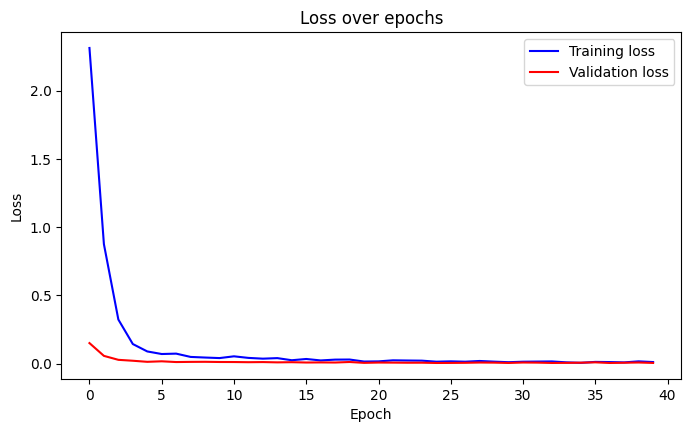

In [27]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [ ]:
x, y = train_dataset[0]

In [ ]:
model(torch.unsqueeze(x, dim=0))